In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#### 1.	Load forest fire prediction dataset

In [ ]:
# download dataset from given link and rename to Algerian_forest_fires_dataset.csv 
# https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++
data=pd.read_csv('/content/Algerian_forest_fires_dataset.csv')
data.shape

(244, 15)

#### 2.	Do the exploratory analysis of the dataset 


In [ ]:
print('Shape: ',data.shape)
#Dataset comprises of 244 observations and 15 characteristics (14 independant and 1 dependant)

Shape:  (244, 15)


In [ ]:
data.info()
# Data has 7 columns of float dtype, 6 of int dtype, 2 of object(string) dtype
# FWI column has one null/missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          244 non-null    int64  
 1   month        244 non-null    int64  
 2   year         244 non-null    int64  
 3   Region       244 non-null    object 
 4   Temperature  244 non-null    int64  
 5    RH          244 non-null    int64  
 6    Ws          244 non-null    int64  
 7   Rain         244 non-null    float64
 8   FFMC         244 non-null    float64
 9   DMC          244 non-null    float64
 10  DC           244 non-null    float64
 11  ISI          244 non-null    float64
 12  BUI          244 non-null    float64
 13  FWI          243 non-null    float64
 14  Classes      244 non-null    object 
dtypes: float64(7), int64(6), object(2)
memory usage: 28.7+ KB


In [ ]:
data.describe()
# There is a large difference between 75th %tile and max value of 'DC' which implies that the outliers have notably larger values

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
count,244.000000,244.000000,244.0,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,243.000000
mean,15.754098,7.500000,2012.0,32.172131,61.938525,15.504098,0.760656,77.887705,14.673361,49.288484,4.774180,16.664754,7.035391
std,8.825059,1.112961,0.0,3.633843,14.884200,2.810178,1.999406,14.337571,12.368039,47.619393,4.175318,14.204824,7.440568
min,1.000000,6.000000,2012.0,22.000000,21.000000,6.000000,0.000000,28.600000,0.700000,6.900000,0.000000,1.100000,0.000000
25%,8.000000,7.000000,2012.0,30.000000,52.000000,14.000000,0.000000,72.075000,5.800000,13.275000,1.400000,6.000000,0.700000
50%,16.000000,7.500000,2012.0,32.000000,63.000000,15.000000,0.000000,83.500000,11.300000,33.100000,3.500000,12.250000,4.200000
75%,23.000000,8.000000,2012.0,35.000000,73.250000,17.000000,0.500000,88.300000,20.750000,68.150000,7.300000,22.525000,11.450000
max,31.000000,9.000000,2012.0,42.000000,90.000000,29.000000,16.800000,96.000000,65.900000,220.400000,19.000000,68.000000,31.100000


#####	Perform univariate analysis by plotting various charts 


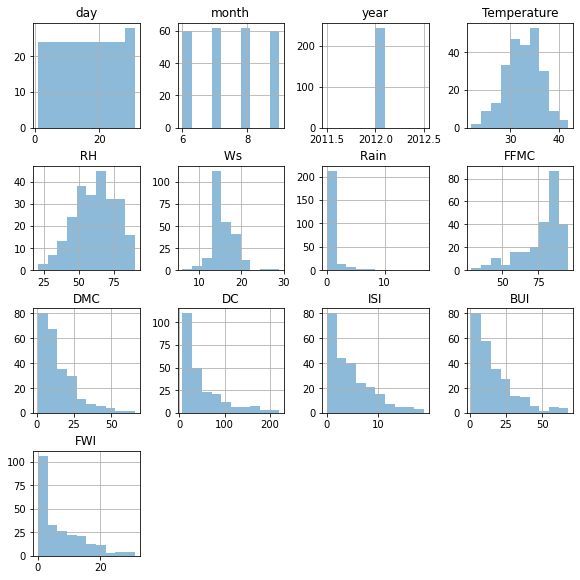

In [ ]:
# histograms
data.hist(alpha=0.5,figsize=(8,8))
plt.tight_layout(pad=0.5)
plt.show()

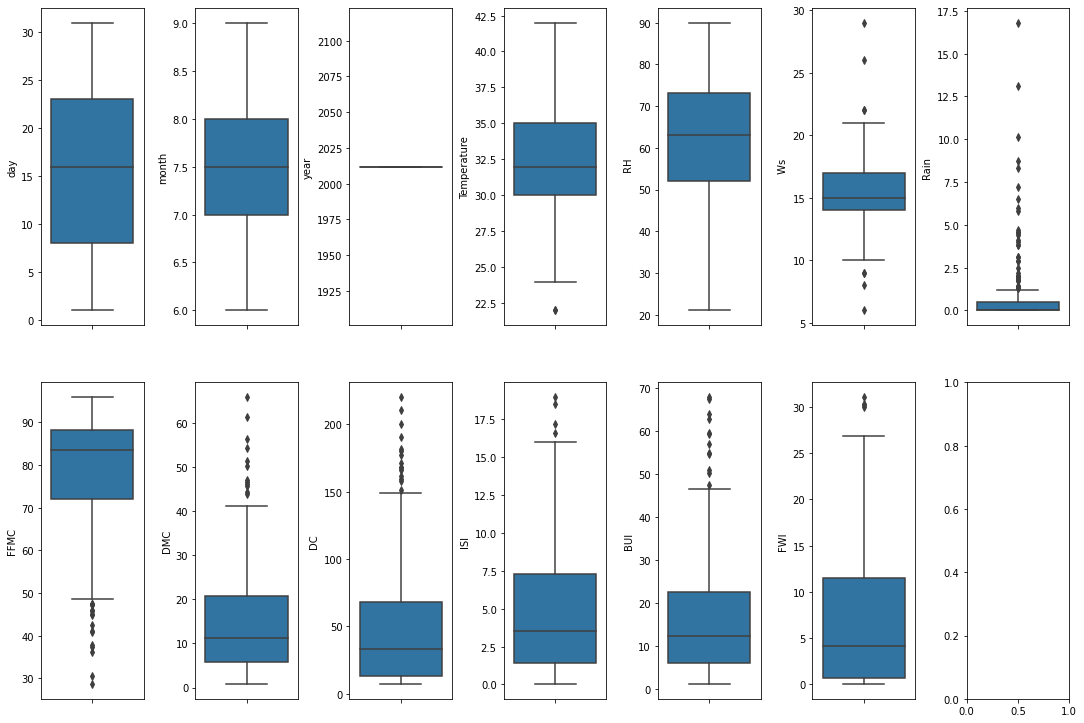

In [ ]:
# boxplots
# box plots to view distribution of values across their range and identify which columns have outliers
numeric_col = data.columns.drop(['Region ','Classes  '])

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(15, 10))
axs = axs.flatten()
i = 0
for c in numeric_col:
    sns.boxplot(y=c, data=data, ax=axs[i])
    i += 1
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)
# Ws, Rain, FFMC, DMC, DC, ISI, BUI, FWI columns have a lot of outliers

##### Perform multivariate analysis 


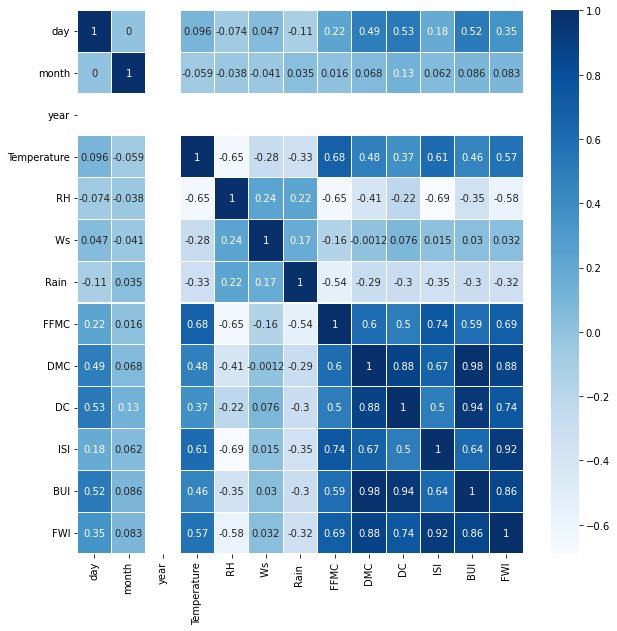

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data=data.corr(),cmap='Blues',annot=True,linewidths=0.2)
# FFMC & ISI, DMC & DC, DMC & BUI, DMC & FWI, DC & BUI, DC & FWI, FWO & ISI, FWI & BUI are highly correlated

#### 3.	Impute the missing values and remove any undesirable feature from the dataset.

In [ ]:
# splitting features and target variable
X = data.iloc[:,:-1]
y = data.iloc[:,-1].str.strip()

In [ ]:
# imputing missing values in FWI column using mean strategy
X['FWI'] = X['FWI'].fillna(X['FWI'].mean())

In [ ]:
# dropping features
# 'year' column has same value for all columns
X = X.drop(['year'],axis=1)

# FFMC & ISI, DMC & DC, DMC & BUI, DMC & FWI, DC & BUI, DC & FWI, FWO & ISI, FWI & BUI are highly correlated
X = X.drop(['DMC', 'ISI', 'DC', 'FWI'],axis=1)


In [ ]:
# Label Encoding target column
from sklearn.preprocessing import LabelEncoder
y=pd.DataFrame(LabelEncoder().fit_transform(y))

# One Hot Encoding categorical column Region
for i in ['Region ']:
  temp = pd.get_dummies(X[i],prefix=i)
  t = X.columns.get_loc(i)
  X = X.drop(labels=i,axis=1)
  for i in range(temp.shape[1]-1,-1,-1):
    X.insert(t, temp.columns[i], temp.iloc[:,i],False)

#### 4.	Check for the outliers in the columns and treat the outliers if present.

In [ ]:
eps=1e-7
# do log transformation of columns with outliers till there are no outliers left (should run max twice)
while 1:
  # checking outliers by using skewness from normal distribution
  o_col=[]
  skew = X.skew()
  for c in X.columns:
    if abs(skew[c])>1:
      o_col.append(c)
  # end the loop if there are no columns with outliers
  if not o_col: break
  # treating outliers by log transforming all columns with skewness
  for c in o_col:
      X[c] = np.maximum(np.full(X[c].shape, eps), np.minimum(np.full(X[c].shape, 1-eps), X[c]))
      X[c] = np.log10(X[c])

#### 5.	Split the dataset into train and test. 


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

#### 6.	Construct a fully grown Decision tree model to predict the fire. 


In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier().fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
# Check whether your model is an overfitted model. 
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train,y_train_pred)
test_acc = accuracy_score(y_test,y_test_pred)

print('Training Accuracy: {}\nTesting Accuracy:  {}'.format(train_acc,test_acc))
# The training accuracy is 1 BUT the testing accuracy is also 0.902 so the model is not overfitted

Training Accuracy: 1.0
Testing Accuracy:  0.9016393442622951


#### 7.	Construct Decision tree models using different hyper-parameter values to restrict the growth of the tree.


In [ ]:
from sklearn.model_selection import GridSearchCV
param = {'criterion'               :['gini','entropy'],
         'splitter'                :['best','random'],
         'max_depth'               :[None,3,4,5],
         'min_samples_split'       :[2,3,4],
         'min_samples_leaf'        :[1,2,3],
         'min_weight_fraction_leaf':[0,0.1,0.2],
         'max_features'            :[None,'sqrt','log2'],
         'random_state'            :[1,2,None],
         'max_leaf_nodes'          :[None,2,3],
         'min_impurity_decrease'   :[0,0.1,0.2],
         'class_weight'            :[None,'balanced'],
         'ccp_alpha'               :[0,0.1,0.2]
         }
model = DecisionTreeClassifier()
clf = GridSearchCV(model,param)
clf.fit(X_train,y_train)

#### 8.	Compare the performance of different 

In [ ]:
# Compare the performance of different decision tree models constructed in step 6 and 7, using various evaluation metrics.
best_model = clf.best_estimator_
print('Parameters of Best Model: ')
for k,i in clf.best_params_.items():
  print('{}: {}'.format(k,i))

Parameters of Best Model: 
ccp_alpha: 0
class_weight: None
criterion: gini
max_depth: 4
max_features: sqrt
max_leaf_nodes: None
min_impurity_decrease: 0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0
random_state: 1
splitter: random


In [ ]:
print('Accuracy of default Model: ',test_acc)
print('Accuracy of Best Model   : ',accuracy_score(y_test,best_model.predict(X_test)))

Accuracy of default Model:  0.9016393442622951
Accuracy of Best Model   :  0.819672131147541


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
split_no = 10
kfcv = KFold(n_splits=split_no, random_state=1, shuffle=True)
kfcv_scores = cross_val_score(model, X, y, scoring='accuracy', cv=kfcv, n_jobs=-1)

print('K-Fold Cross Validation Score of default Model: {} ({})'.format(kfcv_scores.mean(), kfcv_scores.std()))
print('K-Fold Cross Validation Score of Best Model   :',clf.best_score_)

K-Fold Cross Validation Score of default Model: 0.8525 (0.06399327221582665)
K-Fold Cross Validation Score of Best Model   : 0.8692192192192192


#### 9.	Look for real world applications where you can apply Decision Tree classification model.


Business Management

In the past decades, many organizations had created their own databases to enhance their customer services. Decision trees are a possible way to extract useful information from databases and they have already been employed in many applications in the domain of business and management. In particular, decision tree modelling is widely used in customer relationship management and fraud detection.<br><br>

Fraudulent Statement Detection

Another widely used business application is the detection of Fraudulent Financial Statements (FFS). Such an application is particularly important because the existence of FFS may result in reducing the government’s tax income. A traditional way to identify FFS is to employ statistical methods. However, it is difficult to discover all hidden information due to the necessity of making a huge number of assumptions and predefining the relationships among the large number of variables in a financial statement<br><br>

Fault Diagnosis

Another widely used application in the engineering domain is the detection of faults, especially in the identification of a faulty bearing in rotary machineries. This is probably because a bearing is one of the most important components that directly influences the operation of a rotary machine. To detect the existence of a faulty bearing, engineers tend to measure the vibration and acoustic emission (AE) signals emanated from the rotary machine. However, the measurement involves a number of variables, some of which may be less relevant to the investigation. Decision trees are a possible tool to remove such irrelevant variables as they can be used for the purposes of feature selection.